# 🌤️ Weather Model Training - Dual Model (Hourly + Daily)

Notebook ini mengikuti panduan dari `training_guide.md` untuk melatih **dual-model**:
1. **Model Hourly** - Prediksi per-jam (temp, humidity, windspeed, pressure, weather_code)
2. **Model Daily** - Prediksi per-hari (temp_min, temp_max, temp_mean, humidity_avg, windspeed_avg, pressure_avg, weather_code_dominant)

**Output:** 7 file model `.pkl` untuk berbagai kebutuhan deployment.

## 1. Persiapan Lingkungan dan Pemuatan Pustaka

In [11]:
# Install dependencies jika belum ada
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

In [12]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, classification_report, confusion_matrix
)

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost
try:
    from xgboost import XGBRegressor, XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not installed. Skipping XGBoost models.")
    XGBOOST_AVAILABLE = False

# Joblib for saving models
import joblib

print("✅ Semua pustaka berhasil diimpor!")
print(f"   - Pandas: {pd.__version__}")
print(f"   - NumPy: {np.__version__}")
print(f"   - XGBoost Available: {XGBOOST_AVAILABLE}")

✅ Semua pustaka berhasil diimpor!
   - Pandas: 2.0.3
   - NumPy: 1.26.4
   - XGBoost Available: True


## 2. Pengumpulan dan Pemuatan Data

In [13]:
# Load dataset (23 kolom: hourly + daily features)
DATA_PATH = '../data/historical_data_2000_2024_v2.csv'

df = pd.read_csv(DATA_PATH)

# Konversi timestamp ke datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Urutkan berdasarkan waktu (PENTING untuk time-series)
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"📊 Dataset loaded: {len(df):,} baris x {len(df.columns)} kolom")
print(f"📅 Rentang waktu: {df['timestamp'].min()} - {df['timestamp'].max()}")
print(f"\n📋 Kolom dataset:")
print(df.columns.tolist())
df.head()

📊 Dataset loaded: 227,328 baris x 39 kolom
📅 Rentang waktu: 2000-01-01 00:00:00 - 2025-12-06 23:00:00

📋 Kolom dataset:
['id', 'timestamp', 'hour', 'day', 'month', 'year', 'temp', 'humidity', 'windspeed', 'sealevelpressure', 'rain', 'apparent_temperature', 'surface_pressure', 'dew_point_2m', 'wind_direction_10m', 'wind_gusts_10m', 'weather_code', 'conditions', 'temp_max_daily', 'temp_min_daily', 'temp_mean_daily', 'weather_code_daily', 'rain_sum_daily', 'humidity_mean_daily', 'humidity_max_daily', 'humidity_min_daily', 'pressure_msl_mean_daily', 'pressure_msl_max_daily', 'pressure_msl_min_daily', 'surface_pressure_mean_daily', 'surface_pressure_max_daily', 'surface_pressure_min_daily', 'windspeed_mean_daily', 'windspeed_max_daily', 'windspeed_min_daily', 'wind_gusts_mean_daily', 'wind_gusts_max_daily', 'wind_gusts_min_daily', 'wind_direction_dominant_daily']


,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,...,surface_pressure_mean_daily,surface_pressure_max_daily,surface_pressure_min_daily,windspeed_mean_daily,windspeed_max_daily,windspeed_min_daily,wind_gusts_mean_daily,wind_gusts_max_daily,wind_gusts_min_daily,wind_direction_dominant_daily
0,0,2000-01-01 00:00:00,0,1,1,2000,21.8,98,4.0,1008.4,...,983.6,985.4,981.3,6.3,12.1,1.4,17.3,30.2,6.8,300
1,1,2000-01-01 01:00:00,1,1,1,2000,21.4,99,4.0,1007.9,...,983.6,985.4,981.3,6.3,12.1,1.4,17.3,30.2,6.8,300
2,2,2000-01-01 02:00:00,2,1,1,2000,21.4,98,3.2,1007.4,...,983.6,985.4,981.3,6.3,12.1,1.4,17.3,30.2,6.8,300
3,3,2000-01-01 03:00:00,3,1,1,2000,21.2,99,4.6,1007.0,...,983.6,985.4,981.3,6.3,12.1,1.4,17.3,30.2,6.8,300
4,4,2000-01-01 04:00:00,4,1,1,2000,21.0,99,3.6,1006.9,...,983.6,985.4,981.3,6.3,12.1,1.4,17.3,30.2,6.8,300


In [14]:
# Info struktur data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227328 entries, 0 to 227327
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   id                             227328 non-null  int64         
 1   timestamp                      227328 non-null  datetime64[ns]
 2   hour                           227328 non-null  int64         
 3   day                            227328 non-null  int64         
 4   month                          227328 non-null  int64         
 5   year                           227328 non-null  int64         
 6   temp                           227328 non-null  float64       
 7   humidity                       227328 non-null  int64         
 8   windspeed                      227328 non-null  float64       
 9   sealevelpressure               227328 non-null  float64       
 10  rain                           227328 non-null  float64       
 11  

## 3. Analisis Data Eksplorasi (EDA)

### 3.1 Statistik Deskriptif

In [15]:
# Statistik deskriptif untuk fitur numerik
df.describe()

,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,...,surface_pressure_mean_daily,surface_pressure_max_daily,surface_pressure_min_daily,windspeed_mean_daily,windspeed_max_daily,windspeed_min_daily,wind_gusts_mean_daily,wind_gusts_max_daily,wind_gusts_min_daily,wind_direction_dominant_daily
count,227328.000000,227328,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000,...,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000,227328.000000
mean,113663.500000,2012-12-18 23:30:00,11.500000,15.721706,6.508235,2012.466639,25.537423,79.352192,6.158694,1010.092590,...,986.395946,988.209417,984.307791,6.160557,11.302386,1.956123,16.850338,29.357042,6.813936,193.132285
min,0.000000,2000-01-01 00:00:00,0.000000,1.000000,1.000000,2000.000000,17.000000,16.000000,0.000000,1002.200000,...,980.900000,982.100000,978.700000,1.700000,3.700000,0.000000,8.500000,11.500000,0.700000,0.000000
25%,56831.750000,2006-06-25 23:45:00,5.750000,8.000000,4.000000,2006.000000,23.200000,71.000000,3.400000,1008.800000,...,985.500000,987.200000,983.500000,4.300000,8.400000,0.800000,13.500000,24.100000,4.700000,130.000000
50%,113663.500000,2012-12-18 23:30:00,11.500000,16.000000,7.000000,2012.000000,25.000000,83.000000,5.200000,1010.200000,...,986.500000,988.300000,984.400000,5.500000,10.400000,1.500000,15.700000,27.700000,5.800000,158.000000
75%,170495.250000,2019-06-13 23:15:00,17.250000,23.000000,9.000000,2019.000000,27.500000,93.000000,8.000000,1011.400000,...,987.300000,989.200000,985.200000,7.200000,13.300000,2.400000,18.800000,32.800000,7.600000,292.000000
max,227327.000000,2025-12-06 23:00:00,23.000000,31.000000,12.000000,2025.000000,37.800000,100.000000,34.700000,1016.800000,...,990.900000,993.000000,989.400000,26.900000,34.700000,22.900000,58.500000,73.800000,46.400000,360.000000
std,65624.085335,NaN,6.922202,8.802615,3.441810,7.482721,3.021660,16.928281,3.900743,1.867072,...,1.368332,1.470485,1.333132,2.656947,4.188184,1.935618,4.961481,7.465317,3.879874,85.280172


### 3.2 Visualisasi Distribusi

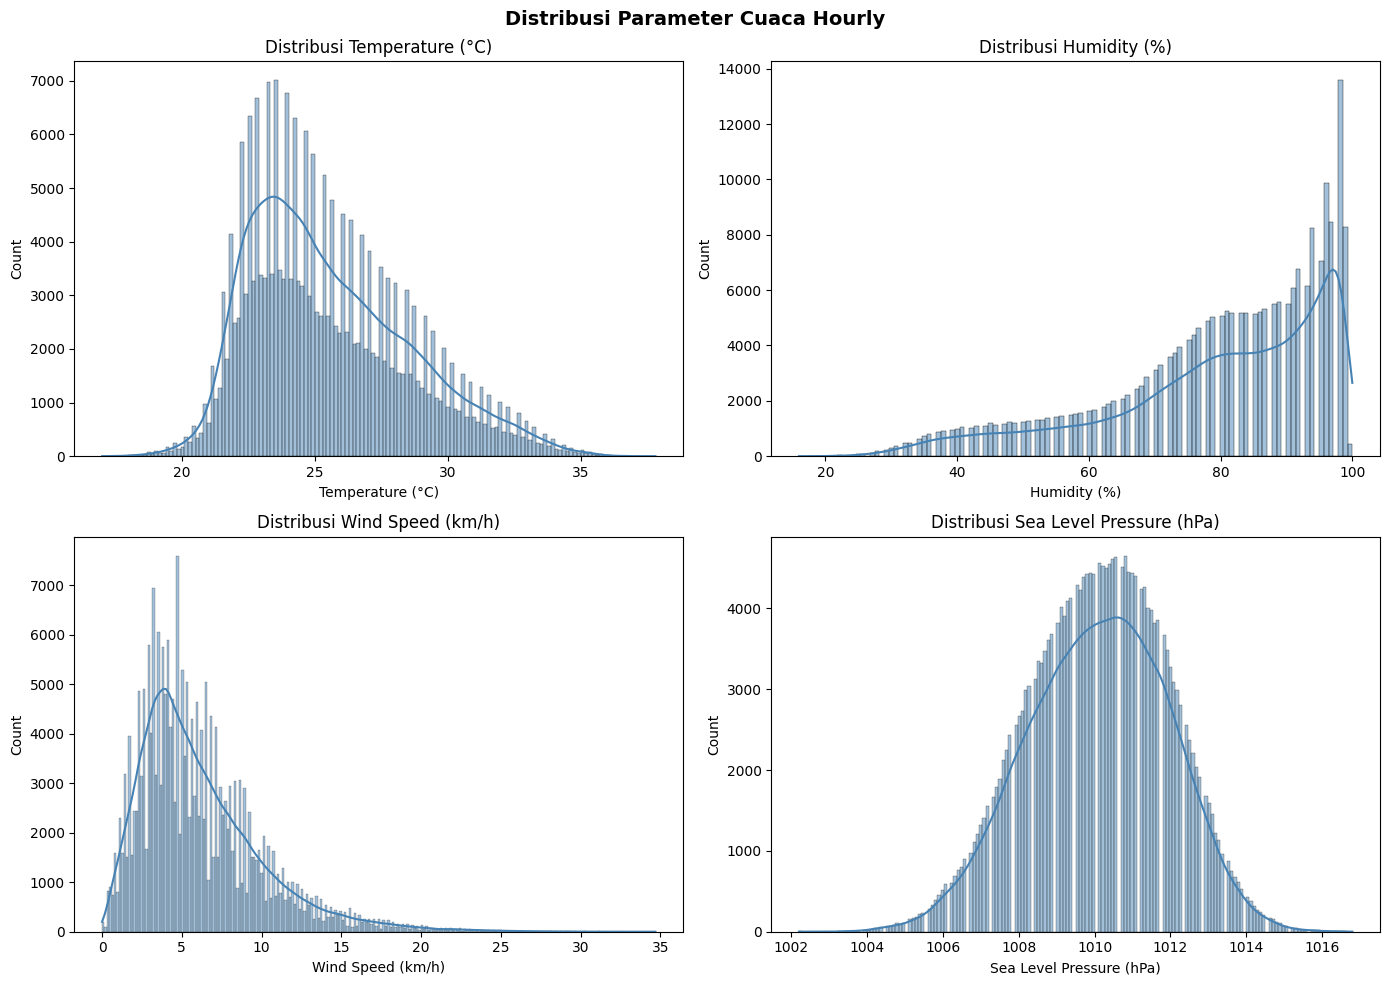

In [16]:
# Visualisasi distribusi parameter cuaca utama (Hourly)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

params = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
titles = ['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Sea Level Pressure (hPa)']

for ax, param, title in zip(axes.flatten(), params, titles):
    sns.histplot(df[param], kde=True, ax=ax, color='steelblue')
    ax.set_title(f'Distribusi {title}')
    ax.set_xlabel(title)

plt.suptitle('Distribusi Parameter Cuaca Hourly', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

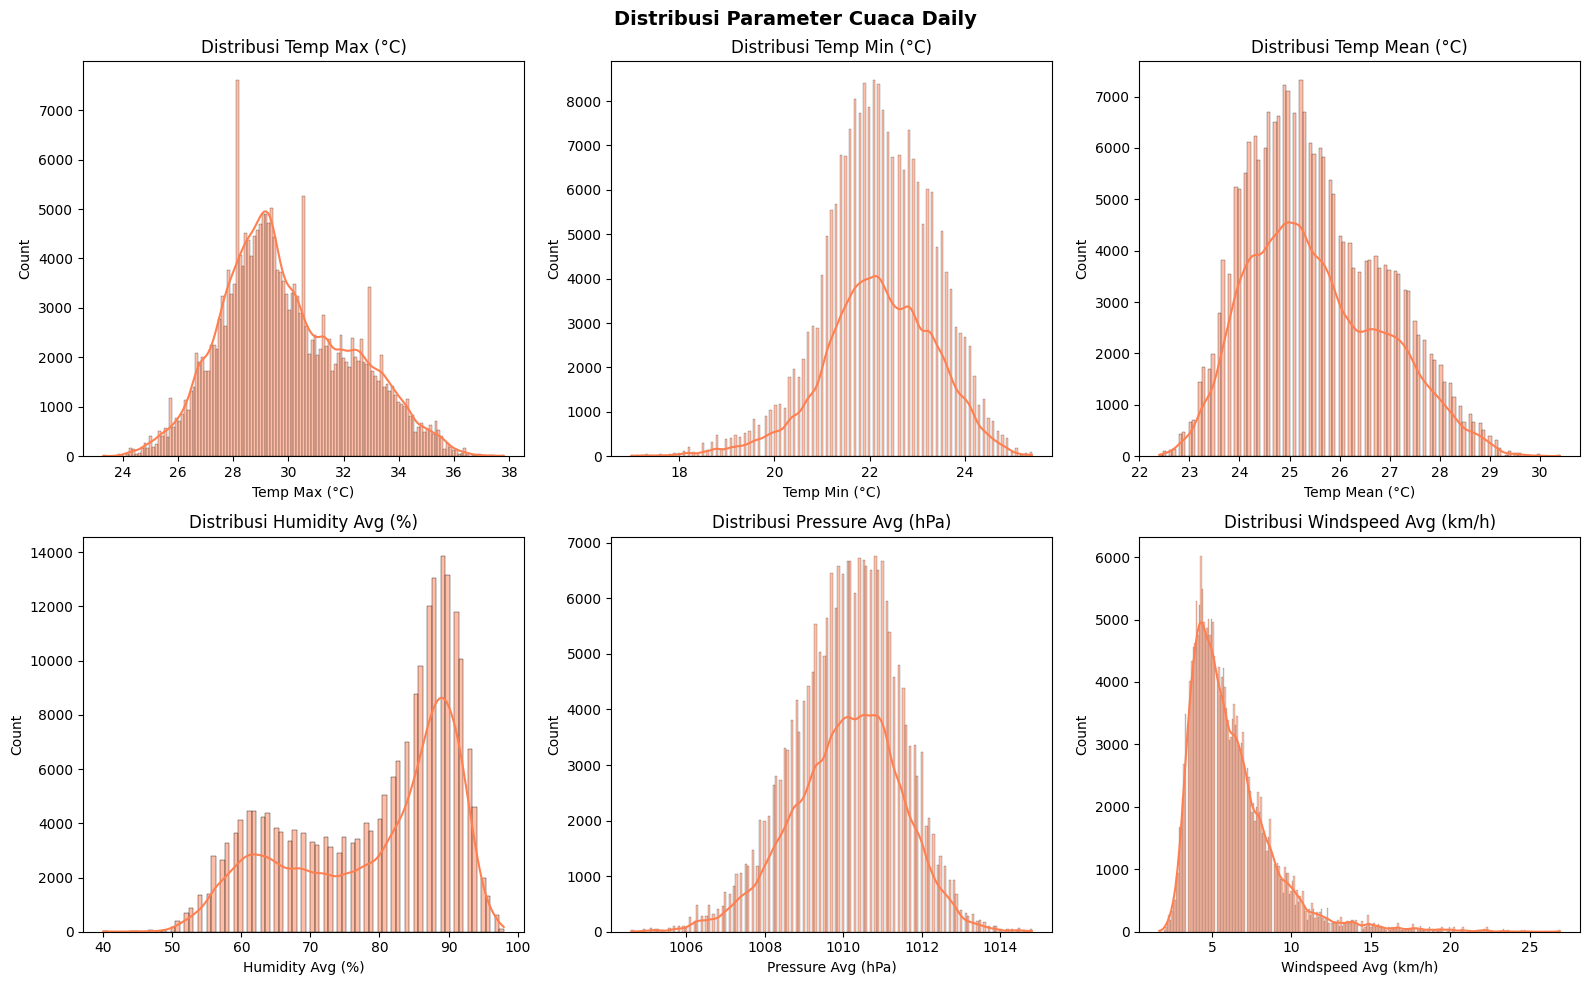

In [18]:
# Visualisasi distribusi parameter cuaca Daily
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

daily_params = ['temp_max_daily', 'temp_min_daily', 'temp_mean_daily', 
                'humidity_mean_daily', 'pressure_msl_mean_daily', 'windspeed_mean_daily']
titles = ['Temp Max (°C)', 'Temp Min (°C)', 'Temp Mean (°C)', 
          'Humidity Avg (%)', 'Pressure Avg (hPa)', 'Windspeed Avg (km/h)']

for ax, param, title in zip(axes.flatten(), daily_params, titles):
    sns.histplot(df[param].dropna(), kde=True, ax=ax, color='coral')
    ax.set_title(f'Distribusi {title}')
    ax.set_xlabel(title)

plt.suptitle('Distribusi Parameter Cuaca Daily', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.3 Analisis Korelasi

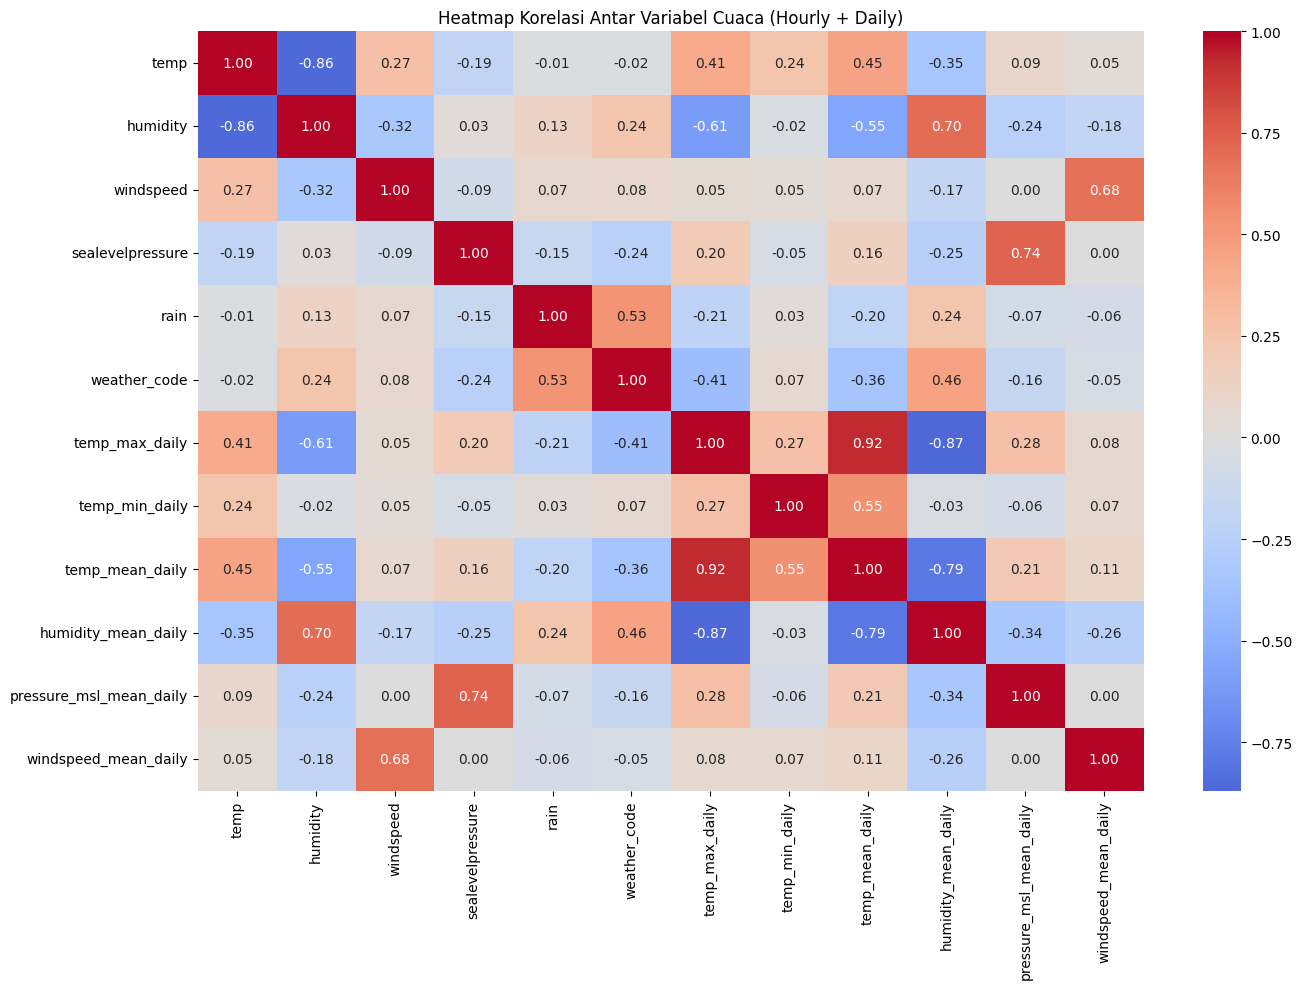

In [20]:
# Heatmap korelasi
numeric_cols = ['temp', 'humidity', 'windspeed', 'sealevelpressure', 'rain', 
                'weather_code', 'temp_max_daily', 'temp_min_daily', 'temp_mean_daily',
                'humidity_mean_daily', 'pressure_msl_mean_daily', 'windspeed_mean_daily']

plt.figure(figsize=(14, 10))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Heatmap Korelasi Antar Variabel Cuaca (Hourly + Daily)')
plt.tight_layout()
plt.show()

### 3.4 Analisis Korelasi: weather_code dan rain

In [21]:
# Analisis hubungan weather_code dengan rain
weather_rain_analysis = df.groupby('weather_code')[['rain']].agg(['mean', 'min', 'max', 'count'])
print("📊 Weather Code vs Rain:")
weather_rain_analysis

📊 Weather Code vs Rain:


rain                  
                   mean  min   max  count
weather_code                             
0              0.000000  0.0   0.0  23299
1              0.000000  0.0   0.0  28623
2              0.000000  0.0   0.0  26366
3              0.000000  0.0   0.0  82011
51             0.205184  0.1   0.4  37114
53             0.661243  0.5   0.9  12421
55             1.091673  1.0   1.2   3783
61             1.743284  1.3   2.4   7333
63             3.949189  2.5   7.5   5794
65            10.288356  7.6  33.4    584

In [24]:
# Verifikasi korelasi deterministik
# print(f"\n🔍 Verifikasi rain == precipitation: {(df['rain'] == df['precipitation']).all()}")
print(f"🔍 Weather codes dengan rain > 0: {sorted(df[df['rain'] > 0]['weather_code'].unique())}")
print(f"🔍 Weather codes dengan rain = 0: {sorted(df[df['rain'] == 0]['weather_code'].unique())}")

# Kesimpulan
print("\n✅ KESIMPULAN:")
print("   - rain dan precipitation IDENTIK di seluruh dataset")
print("   - weather_code >= 50 SELALU hujan (deterministik)")
print("   - Tidak perlu memprediksi rain terpisah, cukup prediksi weather_code")

🔍 Weather codes dengan rain > 0: [51, 53, 55, 61, 63, 65]
🔍 Weather codes dengan rain = 0: [0, 1, 2, 3]

✅ KESIMPULAN:
   - rain dan precipitation IDENTIK di seluruh dataset
   - weather_code >= 50 SELALU hujan (deterministik)
   - Tidak perlu memprediksi rain terpisah, cukup prediksi weather_code


## 4. Pra-pemrosesan Data dan Feature Engineering

### 4.1 Preprocessing Data Hourly

In [25]:
# Copy dataframe untuk preprocessing
df_hourly = df.copy()

# 1. Label Encoding untuk 'conditions'
le_conditions = LabelEncoder()
df_hourly['conditions_encoded'] = le_conditions.fit_transform(df_hourly['conditions'])

print("📝 Label Encoding untuk 'conditions':")
for i, label in enumerate(le_conditions.classes_):
    print(f"   {i}: {label}")

📝 Label Encoding untuk 'conditions':
   0: Clear
   1: Overcast
   2: Partially cloudy
   3: Rain
   4: Rain, Overcast


In [26]:
# 2. Label Encoding untuk 'weather_code' (PENTING untuk XGBoost)
# XGBoost membutuhkan label berupa integer berurutan (0, 1, 2, ...)
le_weather_code = LabelEncoder()
df_hourly['weather_code_encoded'] = le_weather_code.fit_transform(df_hourly['weather_code'])

print("📝 Label Encoding untuk 'weather_code':")
for i, label in enumerate(le_weather_code.classes_):
    print(f"   {i}: {label}")

📝 Label Encoding untuk 'weather_code':
   0: 0
   1: 1
   2: 2
   3: 3
   4: 51
   5: 53
   6: 55
   7: 61
   8: 63
   9: 65


In [27]:
# 3. Feature Engineering: Lag Features untuk Hourly
hourly_target_cols = ['temp', 'humidity', 'windspeed', 'sealevelpressure']

for col in hourly_target_cols:
    # Lag 1 jam
    df_hourly[f'{col}_lag_1'] = df_hourly[col].shift(1)
    # Lag 24 jam
    df_hourly[f'{col}_lag_24'] = df_hourly[col].shift(24)
    # Rolling mean 24 jam
    df_hourly[f'{col}_rolling_24'] = df_hourly[col].rolling(window=24).mean()

print(f"✅ Feature Engineering Hourly selesai! Kolom baru: {12} fitur lag & rolling")

✅ Feature Engineering Hourly selesai! Kolom baru: 12 fitur lag & rolling


In [28]:
# 4. Hapus baris dengan NaN (akibat lag & rolling)
rows_before = len(df_hourly)
df_hourly = df_hourly.dropna().reset_index(drop=True)
rows_after = len(df_hourly)

print(f"🗑️ Baris dihapus (NaN): {rows_before - rows_after:,}")
print(f"📊 Dataset Hourly final: {rows_after:,} baris")

🗑️ Baris dihapus (NaN): 24
📊 Dataset Hourly final: 227,304 baris


### 4.2 Preprocessing Data Daily

In [29]:
# Agregasi data hourly menjadi daily
df_daily = df.groupby(['year', 'month', 'day']).agg({
    'temp': ['min', 'max', 'mean'],
    'humidity': 'mean',
    'windspeed': 'mean',
    'sealevelpressure': 'mean',
    'weather_code': lambda x: x.mode()[0],  # Dominan weather_code
    'rain': 'sum'  # Total curah hujan
}).reset_index()

# Flatten column names
df_daily.columns = ['year', 'month', 'day', 
                    'temp_min', 'temp_max', 'temp_mean',
                    'humidity_avg', 'windspeed_avg', 'pressure_avg',
                    'weather_code_dominant', 'rain_total']

print(f"📊 Dataset Daily: {len(df_daily):,} baris (hari)")
df_daily.head()

📊 Dataset Daily: 9,472 baris (hari)


,year,month,day,temp_min,temp_max,temp_mean,humidity_avg,windspeed_avg,pressure_avg,weather_code_dominant,rain_total
0,2000,1,1,20.8,27.5,24.154167,90.625000,6.304167,1007.329167,3,4.4
1,2000,1,2,21.6,27.0,23.800000,93.208333,7.504167,1007.254167,51,8.8
2,2000,1,3,22.1,24.9,23.333333,96.916667,5.187500,1007.866667,53,16.1
3,2000,1,4,21.9,27.6,24.291667,89.041667,3.600000,1008.354167,51,4.1
4,2000,1,5,21.3,28.9,24.208333,89.750000,3.800000,1009.054167,3,30.7


In [30]:
# Label Encoding untuk 'weather_code_dominant' (PENTING untuk XGBoost)
le_weather_code_daily = LabelEncoder()
df_daily['weather_code_dominant_encoded'] = le_weather_code_daily.fit_transform(df_daily['weather_code_dominant'])

print("📝 Label Encoding untuk 'weather_code_dominant':")
for i, label in enumerate(le_weather_code_daily.classes_):
    print(f"   {i}: {label}")

📝 Label Encoding untuk 'weather_code_dominant':
   0: 0
   1: 1
   2: 2
   3: 3
   4: 51
   5: 53
   6: 55
   7: 61
   8: 63
   9: 65


In [31]:
# Feature Engineering Daily - Lag Features
df_daily['temp_min_lag_1'] = df_daily['temp_min'].shift(1)   # Kemarin
df_daily['temp_max_lag_1'] = df_daily['temp_max'].shift(1)
df_daily['temp_mean_lag_1'] = df_daily['temp_mean'].shift(1)
df_daily['humidity_avg_lag_1'] = df_daily['humidity_avg'].shift(1)
df_daily['windspeed_avg_lag_1'] = df_daily['windspeed_avg'].shift(1)
df_daily['pressure_avg_lag_1'] = df_daily['pressure_avg'].shift(1)

df_daily['temp_min_lag_7'] = df_daily['temp_min'].shift(7)   # Seminggu lalu
df_daily['temp_max_lag_7'] = df_daily['temp_max'].shift(7)
df_daily['temp_mean_lag_7'] = df_daily['temp_mean'].shift(7)
df_daily['rain_total_lag_1'] = df_daily['rain_total'].shift(1)

# Hapus NaN
rows_before = len(df_daily)
df_daily = df_daily.dropna().reset_index(drop=True)
rows_after = len(df_daily)

print(f"🗑️ Baris dihapus (NaN): {rows_before - rows_after:,}")
print(f"📊 Dataset Daily final: {rows_after:,} baris")

🗑️ Baris dihapus (NaN): 7
📊 Dataset Daily final: 9,465 baris


## 5. Pelatihan dan Perbandingan Model

### 5.1 Pemisahan Data (Time-Series Split)

In [32]:
# ===== HOURLY DATA SPLIT =====
hourly_train_size = int(len(df_hourly) * 0.8)
hourly_train = df_hourly[:hourly_train_size]
hourly_test = df_hourly[hourly_train_size:]

print(f"📊 HOURLY Data Split (80-20):")
print(f"   Train: {len(hourly_train):,} baris")
print(f"   Test:  {len(hourly_test):,} baris")

# ===== DAILY DATA SPLIT =====
daily_train_size = int(len(df_daily) * 0.8)
daily_train = df_daily[:daily_train_size]
daily_test = df_daily[daily_train_size:]

print(f"\n📊 DAILY Data Split (80-20):")
print(f"   Train: {len(daily_train):,} baris")
print(f"   Test:  {len(daily_test):,} baris")

📊 HOURLY Data Split (80-20):
   Train: 181,843 baris
   Test:  45,461 baris

📊 DAILY Data Split (80-20):
   Train: 7,572 baris
   Test:  1,893 baris


In [33]:
# ===== DEFINISI FITUR DAN TARGET =====

# HOURLY Features
hourly_feature_cols = [
    'year', 'month', 'day', 'hour',
    'temp_lag_1', 'temp_lag_24', 'temp_rolling_24',
    'humidity_lag_1', 'humidity_lag_24', 'humidity_rolling_24',
    'windspeed_lag_1', 'windspeed_lag_24', 'windspeed_rolling_24',
    'sealevelpressure_lag_1', 'sealevelpressure_lag_24', 'sealevelpressure_rolling_24'
]
hourly_target_reg = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
hourly_target_clf = 'weather_code_encoded'  # Gunakan encoded untuk XGBoost!

# DAILY Features
daily_feature_cols = [
    'year', 'month', 'day',
    'temp_min_lag_1', 'temp_max_lag_1', 'temp_mean_lag_1',
    'humidity_avg_lag_1', 'windspeed_avg_lag_1', 'pressure_avg_lag_1',
    'temp_min_lag_7', 'temp_max_lag_7', 'temp_mean_lag_7',
    'rain_total_lag_1'
]
daily_target_reg = ['temp_min', 'temp_max', 'temp_mean', 'humidity_avg', 'windspeed_avg', 'pressure_avg']
daily_target_clf = 'weather_code_dominant_encoded'  # Gunakan encoded untuk XGBoost!

# Pisahkan X dan y untuk HOURLY
X_hourly_train = hourly_train[hourly_feature_cols]
X_hourly_test = hourly_test[hourly_feature_cols]
y_hourly_train_reg = hourly_train[hourly_target_reg]
y_hourly_test_reg = hourly_test[hourly_target_reg]
y_hourly_train_clf = hourly_train[hourly_target_clf]
y_hourly_test_clf = hourly_test[hourly_target_clf]

# Pisahkan X dan y untuk DAILY
X_daily_train = daily_train[daily_feature_cols]
X_daily_test = daily_test[daily_feature_cols]
y_daily_train_reg = daily_train[daily_target_reg]
y_daily_test_reg = daily_test[daily_target_reg]
y_daily_train_clf = daily_train[daily_target_clf]
y_daily_test_clf = daily_test[daily_target_clf]

print(f"✅ HOURLY Features: {len(hourly_feature_cols)} | Targets Reg: {hourly_target_reg} | Target Clf: {hourly_target_clf}")
print(f"✅ DAILY Features: {len(daily_feature_cols)} | Targets Reg: {daily_target_reg} | Target Clf: {daily_target_clf}")

✅ HOURLY Features: 16 | Targets Reg: ['temp', 'humidity', 'windspeed', 'sealevelpressure'] | Target Clf: weather_code_encoded
✅ DAILY Features: 13 | Targets Reg: ['temp_min', 'temp_max', 'temp_mean', 'humidity_avg', 'windspeed_avg', 'pressure_avg'] | Target Clf: weather_code_dominant_encoded


### 5.2 Komparasi Model Regresi (Hourly)

In [34]:
# Definisi model regresi
regression_models = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
}

if XGBOOST_AVAILABLE:
    regression_models['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

# Fungsi evaluasi
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [35]:
# Training HOURLY Regression Models
print("="*70)
print("🔄 TRAINING HOURLY REGRESSION MODELS")
print("="*70)

hourly_reg_results = []

for name, model in regression_models.items():
    print(f"\n🔄 Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_reg)
    y_pred = model.predict(X_hourly_test)
    
    overall_metrics = evaluate_regression(y_hourly_test_reg, y_pred)
    overall_metrics['Model'] = name
    hourly_reg_results.append(overall_metrics)
    
    print(f"   ✅ {name} - R²: {overall_metrics['R2']:.4f}, RMSE: {overall_metrics['RMSE']:.4f}")

df_hourly_reg = pd.DataFrame(hourly_reg_results).sort_values('R2', ascending=False)
print("\n📊 HASIL PERBANDINGAN REGRESI HOURLY:")
display(df_hourly_reg[['Model', 'R2', 'RMSE', 'MAE']].reset_index(drop=True))

best_hourly_reg_model = df_hourly_reg.iloc[0]['Model']
print(f"\n🏆 MODEL TERBAIK REGRESI HOURLY: {best_hourly_reg_model}")

🔄 TRAINING HOURLY REGRESSION MODELS

🔄 Training Linear Regression...
   ✅ Linear Regression - R²: 0.9009, RMSE: 2.2577

🔄 Training K-Neighbors...
   ✅ K-Neighbors - R²: 0.7958, RMSE: 2.4733

🔄 Training Decision Tree...
   ✅ Decision Tree - R²: 0.7838, RMSE: 2.4442

🔄 Training Random Forest...
   ✅ Random Forest - R²: 0.8931, RMSE: 2.0982

🔄 Training XGBoost...
   ✅ XGBoost - R²: 0.9226, RMSE: 2.0232

📊 HASIL PERBANDINGAN REGRESI HOURLY:


,Model,R2,RMSE,MAE
0,XGBoost,0.922634,2.023245,1.142867
1,Linear Regression,0.900926,2.257713,1.298058
2,Random Forest,0.893066,2.098222,1.267511
3,K-Neighbors,0.795832,2.473350,1.615682
4,Decision Tree,0.783850,2.444172,1.590963



🏆 MODEL TERBAIK REGRESI HOURLY: XGBoost


### 5.3 Komparasi Model Klasifikasi (Hourly)

In [36]:
# Definisi model klasifikasi
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}

if XGBOOST_AVAILABLE:
    # XGBoost membutuhkan num_class untuk multiclass klasifikasi
    num_classes_hourly = len(le_weather_code.classes_)
    classification_models['XGBoost'] = XGBClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1, 
        verbosity=0,
        objective='multi:softmax',
        num_class=num_classes_hourly
    )

In [37]:
# Training HOURLY Classification Models
print("="*70)
print("🔄 TRAINING HOURLY CLASSIFICATION MODELS")
print("="*70)

hourly_clf_results = []

for name, model in classification_models.items():
    print(f"\n🔄 Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_clf)
    y_pred = model.predict(X_hourly_test)
    
    accuracy = accuracy_score(y_hourly_test_clf, y_pred)
    f1_weighted = f1_score(y_hourly_test_clf, y_pred, average='weighted', zero_division=0)
    
    hourly_clf_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 (Weighted)': f1_weighted
    })
    
    print(f"   ✅ {name} - Accuracy: {accuracy:.4f}, F1: {f1_weighted:.4f}")

df_hourly_clf = pd.DataFrame(hourly_clf_results).sort_values('Accuracy', ascending=False)
print("\n📊 HASIL PERBANDINGAN KLASIFIKASI HOURLY:")
display(df_hourly_clf.reset_index(drop=True))

best_hourly_clf_model = df_hourly_clf.iloc[0]['Model']
print(f"\n🏆 MODEL TERBAIK KLASIFIKASI HOURLY: {best_hourly_clf_model}")

🔄 TRAINING HOURLY CLASSIFICATION MODELS

🔄 Training Logistic Regression...
   ✅ Logistic Regression - Accuracy: 0.4371, F1: 0.3379

🔄 Training Decision Tree...
   ✅ Decision Tree - Accuracy: 0.4199, F1: 0.3651

🔄 Training Random Forest...
   ✅ Random Forest - Accuracy: 0.4424, F1: 0.3853

🔄 Training XGBoost...
   ✅ XGBoost - Accuracy: 0.4481, F1: 0.3944

📊 HASIL PERBANDINGAN KLASIFIKASI HOURLY:


,Model,Accuracy,F1 (Weighted)
0,XGBoost,0.448076,0.394407
1,Random Forest,0.442357,0.385300
2,Logistic Regression,0.437056,0.337939
3,Decision Tree,0.419898,0.365057



🏆 MODEL TERBAIK KLASIFIKASI HOURLY: XGBoost


### 5.4 Komparasi Model Regresi (Daily)

In [38]:
# Training DAILY Regression Models
print("="*70)
print("🔄 TRAINING DAILY REGRESSION MODELS")
print("="*70)

daily_reg_results = []

# Re-initialize models
regression_models_daily = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    regression_models_daily['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

for name, model in regression_models_daily.items():
    print(f"\n🔄 Training {name}...")
    model.fit(X_daily_train, y_daily_train_reg)
    y_pred = model.predict(X_daily_test)
    
    overall_metrics = evaluate_regression(y_daily_test_reg, y_pred)
    overall_metrics['Model'] = name
    daily_reg_results.append(overall_metrics)
    
    print(f"   ✅ {name} - R²: {overall_metrics['R2']:.4f}, RMSE: {overall_metrics['RMSE']:.4f}")

df_daily_reg = pd.DataFrame(daily_reg_results).sort_values('R2', ascending=False)
print("\n📊 HASIL PERBANDINGAN REGRESI DAILY:")
display(df_daily_reg[['Model', 'R2', 'RMSE', 'MAE']].reset_index(drop=True))

best_daily_reg_model = df_daily_reg.iloc[0]['Model']
print(f"\n🏆 MODEL TERBAIK REGRESI DAILY: {best_daily_reg_model}")

🔄 TRAINING DAILY REGRESSION MODELS

🔄 Training Linear Regression...
   ✅ Linear Regression - R²: 0.7043, RMSE: 2.0664

🔄 Training K-Neighbors...
   ✅ K-Neighbors - R²: 0.4355, RMSE: 2.3661

🔄 Training Decision Tree...
   ✅ Decision Tree - R²: 0.4306, RMSE: 2.6044

🔄 Training Random Forest...
   ✅ Random Forest - R²: 0.6504, RMSE: 2.0970

🔄 Training XGBoost...
   ✅ XGBoost - R²: 0.6577, RMSE: 2.1682

📊 HASIL PERBANDINGAN REGRESI DAILY:


,Model,R2,RMSE,MAE
0,Linear Regression,0.704296,2.066364,1.158393
1,XGBoost,0.657683,2.168214,1.231838
2,Random Forest,0.650410,2.096957,1.213277
3,K-Neighbors,0.435467,2.366104,1.420989
4,Decision Tree,0.430637,2.604375,1.485820



🏆 MODEL TERBAIK REGRESI DAILY: Linear Regression


### 5.5 Komparasi Model Klasifikasi (Daily)

In [39]:
# Training DAILY Classification Models
print("="*70)
print("🔄 TRAINING DAILY CLASSIFICATION MODELS")
print("="*70)

daily_clf_results = []

# Re-initialize models
num_classes_daily = len(le_weather_code_daily.classes_)
classification_models_daily = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    classification_models_daily['XGBoost'] = XGBClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1, 
        verbosity=0,
        objective='multi:softmax',
        num_class=num_classes_daily
    )

for name, model in classification_models_daily.items():
    print(f"\n🔄 Training {name}...")
    model.fit(X_daily_train, y_daily_train_clf)
    y_pred = model.predict(X_daily_test)
    
    accuracy = accuracy_score(y_daily_test_clf, y_pred)
    f1_weighted = f1_score(y_daily_test_clf, y_pred, average='weighted', zero_division=0)
    
    daily_clf_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 (Weighted)': f1_weighted
    })
    
    print(f"   ✅ {name} - Accuracy: {accuracy:.4f}, F1: {f1_weighted:.4f}")

df_daily_clf = pd.DataFrame(daily_clf_results).sort_values('Accuracy', ascending=False)
print("\n📊 HASIL PERBANDINGAN KLASIFIKASI DAILY:")
display(df_daily_clf.reset_index(drop=True))

best_daily_clf_model = df_daily_clf.iloc[0]['Model']
print(f"\n🏆 MODEL TERBAIK KLASIFIKASI DAILY: {best_daily_clf_model}")

🔄 TRAINING DAILY CLASSIFICATION MODELS

🔄 Training Logistic Regression...
   ✅ Logistic Regression - Accuracy: 0.6498, F1: 0.5553

🔄 Training Decision Tree...
   ✅ Decision Tree - Accuracy: 0.5642, F1: 0.5485

🔄 Training Random Forest...
   ✅ Random Forest - Accuracy: 0.6329, F1: 0.5686

🔄 Training XGBoost...
   ✅ XGBoost - Accuracy: 0.5663, F1: 0.5546

📊 HASIL PERBANDINGAN KLASIFIKASI DAILY:


,Model,Accuracy,F1 (Weighted)
0,Logistic Regression,0.649762,0.555340
1,Random Forest,0.632858,0.568595
2,XGBoost,0.566297,0.554649
3,Decision Tree,0.564184,0.548511



🏆 MODEL TERBAIK KLASIFIKASI DAILY: Logistic Regression


### 5.6 Kesimpulan Pemilihan Model

In [40]:
print("="*70)
print("🎯 KESIMPULAN PEMILIHAN MODEL TERBAIK")
print("="*70)

print("\n📈 MODEL HOURLY:")
print(f"   🏆 Regresi: {best_hourly_reg_model} (R²: {df_hourly_reg.iloc[0]['R2']:.4f})")
print(f"   🏆 Klasifikasi: {best_hourly_clf_model} (Acc: {df_hourly_clf.iloc[0]['Accuracy']:.4f})")

print("\n📊 MODEL DAILY:")
print(f"   🏆 Regresi: {best_daily_reg_model} (R²: {df_daily_reg.iloc[0]['R2']:.4f})")
print(f"   🏆 Klasifikasi: {best_daily_clf_model} (Acc: {df_daily_clf.iloc[0]['Accuracy']:.4f})")

print("\n" + "="*70)
print("✅ Langkah selanjutnya: Retraining dengan 100% data, lalu simpan 7 file model")
print("="*70)

🎯 KESIMPULAN PEMILIHAN MODEL TERBAIK

📈 MODEL HOURLY:
   🏆 Regresi: XGBoost (R²: 0.9226)
   🏆 Klasifikasi: XGBoost (Acc: 0.4481)

📊 MODEL DAILY:
   🏆 Regresi: Linear Regression (R²: 0.7043)
   🏆 Klasifikasi: Logistic Regression (Acc: 0.6498)

✅ Langkah selanjutnya: Retraining dengan 100% data, lalu simpan 7 file model


## 6. Analisis Hasil dan Kinerja Individual Parameter

### 6.1 Evaluasi Per-Parameter (Regresi Hourly)

In [41]:
# Evaluasi kinerja per-parameter untuk model terbaik (Hourly)
print("="*70)
print("EVALUASI PER-PARAMETER (REGRESI HOURLY)")
print("="*70)

# Gunakan model terbaik dari perbandingan
if XGBOOST_AVAILABLE:
    best_reg_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
else:
    best_reg_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
best_reg_model.fit(X_hourly_train, y_hourly_train_reg)
y_pred = best_reg_model.predict(X_hourly_test)

# Evaluasi per parameter
param_results = []
for i, param in enumerate(hourly_target_reg):
    mae = mean_absolute_error(y_hourly_test_reg.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_hourly_test_reg.iloc[:, i], y_pred[:, i]))
    r2 = r2_score(y_hourly_test_reg.iloc[:, i], y_pred[:, i])
    param_results.append({"Parameter": param, "MAE": mae, "RMSE": rmse, "R2": r2})

df_param_results = pd.DataFrame(param_results)
display(df_param_results)

EVALUASI PER-PARAMETER (REGRESI HOURLY)


,Parameter,MAE,RMSE,R2
0,temp,0.371930,0.548189,0.965402
1,humidity,2.472978,3.449840,0.953498
2,windspeed,1.509327,2.022938,0.796113
3,sealevelpressure,0.217235,0.282764,0.975524


### 6.2 Evaluasi Klasifikasi (Weather Code) Hourly - Confusion Matrix

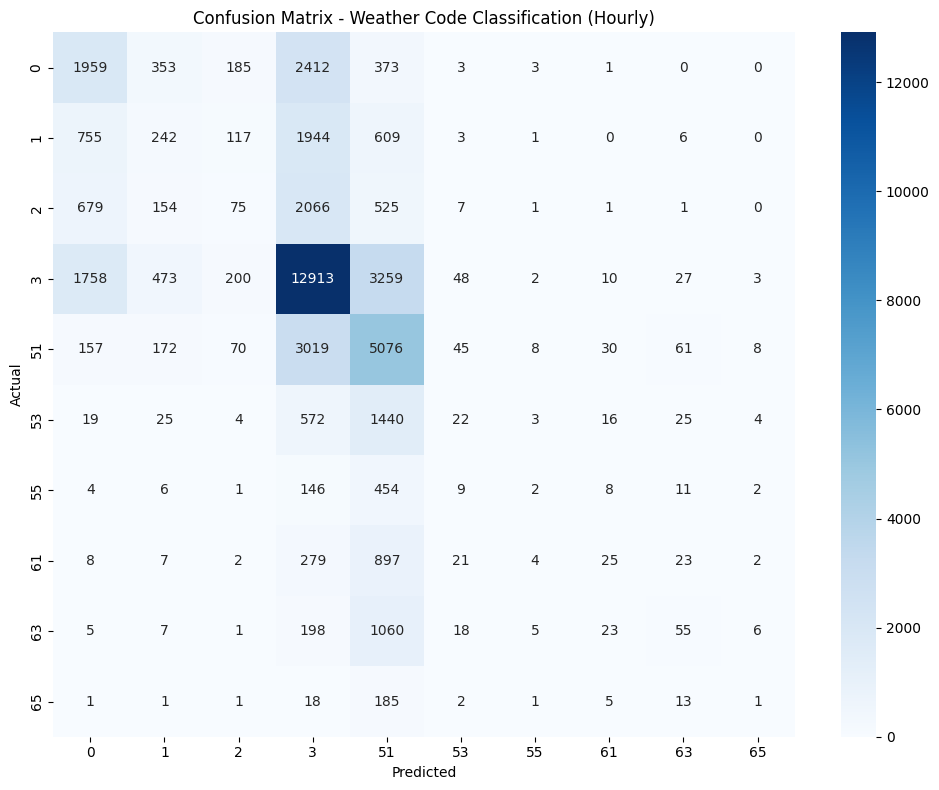

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.37      0.37      5289
           1       0.17      0.07      0.09      3677
           2       0.11      0.02      0.04      3509
           3       0.55      0.69      0.61     18693
          51       0.37      0.59      0.45      8646
          53       0.12      0.01      0.02      2130
          55       0.07      0.00      0.01       643
          61       0.21      0.02      0.04      1268
          63       0.25      0.04      0.07      1378
          65       0.04      0.00      0.01       228

    accuracy                           0.45     45461
   macro avg       0.22      0.18      0.17     45461
weighted avg       0.38      0.45      0.39     45461



In [42]:
# Confusion Matrix untuk klasifikasi weather_code
best_clf_model = XGBClassifier(        
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1, 
    verbosity=0,
    objective='multi:softmax',
    num_class=num_classes_daily
)
best_clf_model.fit(X_hourly_train, y_hourly_train_clf)
y_pred_clf = best_clf_model.predict(X_hourly_test)

# Confusion Matrix
cm = confusion_matrix(y_hourly_test_clf, y_pred_clf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_weather_code.classes_,
            yticklabels=le_weather_code.classes_)
plt.title("Confusion Matrix - Weather Code Classification (Hourly)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_hourly_test_clf, y_pred_clf,
                          target_names=[str(c) for c in le_weather_code.classes_]))

### 6.3 Evaluasi Per-Parameter (Regresi Daily)

In [43]:
# Evaluasi kinerja per-parameter untuk model terbaik (Daily)
print("="*70)
print("EVALUASI PER-PARAMETER (REGRESI DAILY)")
print("="*70)

# best_daily_reg = LinearRegression()
best_daily_reg = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
best_daily_reg.fit(X_daily_train, y_daily_train_reg)
y_pred_daily = best_daily_reg.predict(X_daily_test)

daily_param_results = []
for i, param in enumerate(daily_target_reg):
    mae = mean_absolute_error(y_daily_test_reg.iloc[:, i], y_pred_daily[:, i])
    rmse = np.sqrt(mean_squared_error(y_daily_test_reg.iloc[:, i], y_pred_daily[:, i]))
    r2 = r2_score(y_daily_test_reg.iloc[:, i], y_pred_daily[:, i])
    daily_param_results.append({"Parameter": param, "MAE": mae, "RMSE": rmse, "R2": r2})

df_daily_param = pd.DataFrame(daily_param_results)
display(df_daily_param)

EVALUASI PER-PARAMETER (REGRESI DAILY)


,Parameter,MAE,RMSE,R2
0,temp_min,0.519250,0.689063,0.377310
1,temp_max,0.838804,1.104776,0.789383
2,temp_mean,0.478035,0.616488,0.746506
3,humidity_avg,3.572131,4.658529,0.805675
4,windspeed_avg,1.430492,1.985214,0.503956
5,pressure_avg,0.552321,0.698964,0.723270


### 6.2 Evaluasi Klasifikasi (Weather Code) Daily - Confusion Matrix

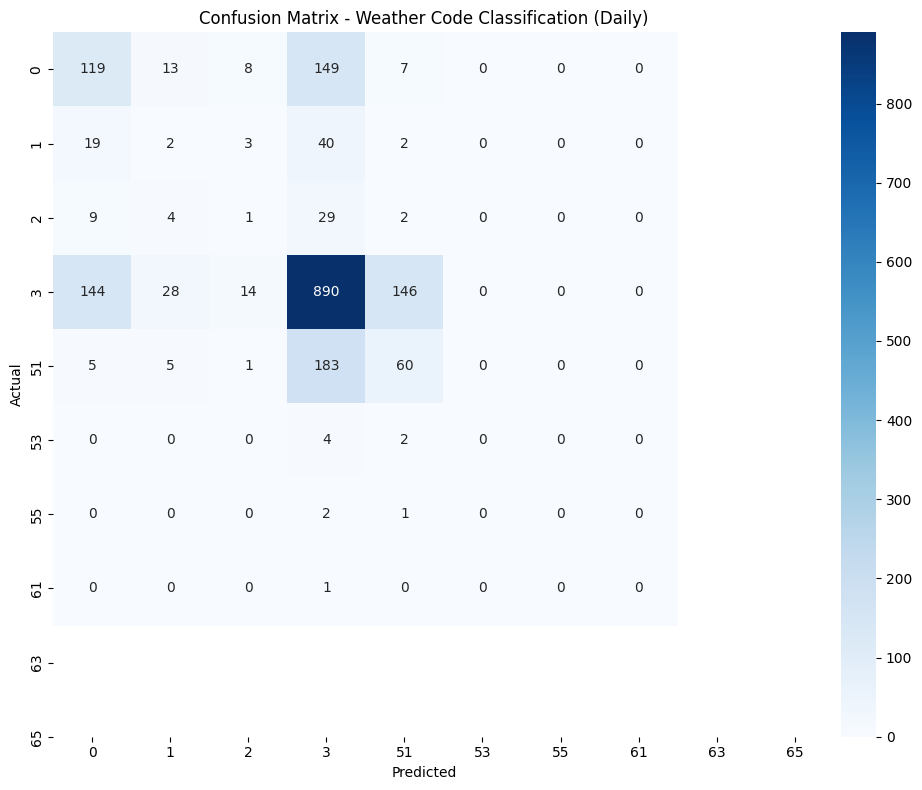

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40       296
           1       0.04      0.03      0.03        66
           2       0.04      0.02      0.03        45
           3       0.69      0.73      0.71      1222
          51       0.27      0.24      0.25       254
          53       0.00      0.00      0.00         6
          55       0.00      0.00      0.00         0
          61       0.00      0.00      0.00         3
          63       0.00      0.00      0.00         1
          65       0.00      0.00      0.00         0

    accuracy                           0.57      1893
   macro avg       0.14      0.14      0.14      1893
weighted avg       0.54      0.57      0.55      1893



In [44]:
# Confusion Matrix untuk klasifikasi weather_code
best_clf_model = XGBClassifier(        
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1, 
    verbosity=0,
    objective='multi:softmax',
    num_class=num_classes_daily
)
best_clf_model.fit(X_daily_train, y_daily_train_clf)
y_pred_daily_clf = best_clf_model.predict(X_daily_test)

# Confusion Matrix
cm = confusion_matrix(y_daily_test_clf, y_pred_daily_clf)
plt.figure(figsize=(10, 8))
# FIX: Use the correct label encoder for daily data (le_weather_code_daily)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_weather_code_daily.classes_,
            yticklabels=le_weather_code_daily.classes_)
plt.title("Confusion Matrix - Weather Code Classification (Daily)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("Classification Report:")
# FIX: Use the correct daily label encoder and add the 'labels' parameter to match.
# Added 'zero_division=0' to prevent warnings for classes with no predictions.
print(classification_report(y_daily_test_clf, y_pred_daily_clf,
                          labels=le_weather_code_daily.transform(le_weather_code_daily.classes_),
                          target_names=[str(c) for c in le_weather_code_daily.classes_],
                          zero_division=0))

### 6.3  Data

## 6.5 Retraining dengan Seluruh Dataset (Final Model)

In [45]:
# Gabung train + test untuk final training
X_hourly_full = df_hourly[hourly_feature_cols]
y_hourly_reg_full = df_hourly[hourly_target_reg]
y_hourly_clf_full = df_hourly[hourly_target_clf]

X_daily_full = df_daily[daily_feature_cols]
y_daily_reg_full = df_daily[daily_target_reg]
y_daily_clf_full = df_daily[daily_target_clf]

print(f"Full Hourly Data: {len(X_hourly_full):,} baris")
print(f"Full Daily Data: {len(X_daily_full):,} baris")

Full Hourly Data: 227,304 baris
Full Daily Data: 9,465 baris


In [46]:
# Training Final Models dengan 100% Data
print("="*70)
print("TRAINING FINAL MODELS (100% DATA)")
print("="*70)

# HOURLY Models
print("Training Hourly Regressor...")
hourly_regressor = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
hourly_regressor.fit(X_hourly_full, y_hourly_reg_full)
print("   Hourly Regressor trained")

print("Training Hourly Classifier...")
hourly_classifier = XGBClassifier(        
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1, 
    verbosity=0,
    objective='multi:softmax',
    num_class=num_classes_daily
)
hourly_classifier.fit(X_hourly_full, y_hourly_clf_full)
print("   Hourly Classifier trained")

# DAILY Models
print("Training Daily Regressor...")
daily_regressor =  XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
daily_regressor.fit(X_daily_full, y_daily_reg_full)
print("   Daily Regressor trained")

print("Training Daily Classifier...")
daily_classifier = XGBClassifier(        
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1, 
    verbosity=0,
    objective='multi:softmax',
    num_class=num_classes_daily
)
daily_classifier.fit(X_daily_full, y_daily_clf_full)
print("   Daily Classifier trained")

print("="*70)
print("ALL 4 FINAL MODELS TRAINED SUCCESSFULLY!")
print("="*70)

TRAINING FINAL MODELS (100% DATA)
Training Hourly Regressor...
   Hourly Regressor trained
Training Hourly Classifier...
   Hourly Classifier trained
Training Daily Regressor...
   Daily Regressor trained
Training Daily Classifier...
   Daily Classifier trained
ALL 4 FINAL MODELS TRAINED SUCCESSFULLY!


## 7. Penyimpanan Model Terbaik (7 File .pkl)

In [47]:
# Pastikan folder models ada
os.makedirs("models", exist_ok=True)

# Weather code to rain mapping
weather_code_to_rain = {0:0, 1:0, 2:0, 3:0, 51:0.2, 53:0.7, 55:1.1, 61:1.7, 63:4.0, 65:10.3}

# 1. COMBINED MODEL
combined_package = {
    "hourly": {
        "regressor": hourly_regressor,
        "classifier": hourly_classifier,
        "feature_columns": hourly_feature_cols,
        "target_regression": hourly_target_reg,
        "target_classification": "weather_code",
    },
    "daily": {
        "regressor": daily_regressor,
        "classifier": daily_classifier,
        "feature_columns": daily_feature_cols,
        "target_regression": daily_target_reg,
        "target_classification": "weather_code_dominant",
    },
    "label_encoder_hourly": le_weather_code,
    "label_encoder_daily": le_weather_code_daily,
    "label_encoder_conditions": le_conditions,
    "weather_code_to_rain": weather_code_to_rain,
    "version": "2.1",
    "trained_date": datetime.now().isoformat(),
    "model_type": "combined"
}
joblib.dump(combined_package, "models/weather_model_combined.pkl")
print("1. Combined model saved")

# 2. HOURLY MODEL
hourly_package = {
    "regressor": hourly_regressor,
    "classifier": hourly_classifier,
    "feature_columns": hourly_feature_cols,
    "target_regression": hourly_target_reg,
    "target_classification": "weather_code",
    "label_encoder": le_weather_code,
    "label_encoder_conditions": le_conditions,
    "weather_code_to_rain": weather_code_to_rain,
    "version": "2.1",
    "trained_date": datetime.now().isoformat(),
    "model_type": "hourly"
}
joblib.dump(hourly_package, "models/weather_model_hourly.pkl")
print("2. Hourly model saved")

# 3. DAILY MODEL
daily_package = {
    "regressor": daily_regressor,
    "classifier": daily_classifier,
    "feature_columns": daily_feature_cols,
    "target_regression": daily_target_reg,
    "target_classification": "weather_code_dominant",
    "label_encoder": le_weather_code_daily,
    "weather_code_to_rain": weather_code_to_rain,
    "version": "2.1",
    "trained_date": datetime.now().isoformat(),
    "model_type": "daily"
}
joblib.dump(daily_package, "models/weather_model_daily.pkl")
print("3. Daily model saved")

1. Combined model saved
2. Hourly model saved
3. Daily model saved


In [48]:
# 4-7. SEPARATE REGRESSOR & CLASSIFIER FILES

# 4. Hourly Regressor Only
hourly_reg_package = {
    "model": hourly_regressor,
    "feature_columns": hourly_feature_cols,
    "target": hourly_target_reg,
    "version": "2.1",
    "model_type": "hourly_regressor"
}
joblib.dump(hourly_reg_package, "models/weather_model_hourly_regressor.pkl")
print("4. Hourly regressor saved")

# 5. Hourly Classifier Only
hourly_clf_package = {
    "model": hourly_classifier,
    "feature_columns": hourly_feature_cols,
    "target": "weather_code",
    "label_encoder": le_weather_code,
    "weather_code_to_rain": weather_code_to_rain,
    "version": "2.1",
    "model_type": "hourly_classifier"
}
joblib.dump(hourly_clf_package, "models/weather_model_hourly_classifier.pkl")
print("5. Hourly classifier saved")

# 6. Daily Regressor Only
daily_reg_package = {
    "model": daily_regressor,
    "feature_columns": daily_feature_cols,
    "target": daily_target_reg,
    "version": "2.1",
    "model_type": "daily_regressor"
}
joblib.dump(daily_reg_package, "models/weather_model_daily_regressor.pkl")
print("6. Daily regressor saved")

# 7. Daily Classifier Only
daily_clf_package = {
    "model": daily_classifier,
    "feature_columns": daily_feature_cols,
    "target": "weather_code_dominant",
    "label_encoder": le_weather_code_daily,
    "weather_code_to_rain": weather_code_to_rain,
    "version": "2.1",
    "model_type": "daily_classifier"
}
joblib.dump(daily_clf_package, "models/weather_model_daily_classifier.pkl")
print("7. Daily classifier saved")

print(f"\nTotal: 7 model files created in models/ folder!")

4. Hourly regressor saved
5. Hourly classifier saved
6. Daily regressor saved
7. Daily classifier saved

Total: 7 model files created in models/ folder!


## 8. Load Model & Persiapan Inference

In [49]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# 1. Muat Model yang sudah dilatih
model_path = 'models/weather_model_combined.pkl'
print(f"🔄 Memuat model dari {model_path}...")

try:
    model_package = joblib.load(model_path)
    print("✅ Model berhasil dimuat!")
except FileNotFoundError:
    print("❌ File model tidak ditemukan. Pastikan Anda sudah menjalankan tahap saving model.")

# 2. Ekstrak komponen model HOURLY
hourly_reg = model_package['hourly']['regressor']
hourly_clf = model_package['hourly']['classifier']
hourly_features = model_package['hourly']['feature_columns']
le_hourly = model_package['label_encoder_hourly']

# 3. Ekstrak komponen model DAILY
daily_reg = model_package['daily']['regressor']
daily_clf = model_package['daily']['classifier']
daily_features = model_package['daily']['feature_columns']
le_daily = model_package['label_encoder_daily']

# Metadata hujan (jika diperlukan untuk mapping)
rain_map = model_package['weather_code_to_rain']

print("\n📋 Fitur Hourly yang dibutuhkan model:", hourly_features)
print("📋 Fitur Daily yang dibutuhkan model:", daily_features)

🔄 Memuat model dari models/weather_model_combined.pkl...
✅ Model berhasil dimuat!

📋 Fitur Hourly yang dibutuhkan model: ['year', 'month', 'day', 'hour', 'temp_lag_1', 'temp_lag_24', 'temp_rolling_24', 'humidity_lag_1', 'humidity_lag_24', 'humidity_rolling_24', 'windspeed_lag_1', 'windspeed_lag_24', 'windspeed_rolling_24', 'sealevelpressure_lag_1', 'sealevelpressure_lag_24', 'sealevelpressure_rolling_24']
📋 Fitur Daily yang dibutuhkan model: ['year', 'month', 'day', 'temp_min_lag_1', 'temp_max_lag_1', 'temp_mean_lag_1', 'humidity_avg_lag_1', 'windspeed_avg_lag_1', 'pressure_avg_lag_1', 'temp_min_lag_7', 'temp_max_lag_7', 'temp_mean_lag_7', 'rain_total_lag_1']


## 9. Fungsi Prediksi Rekursif (Hourly & Daily)

Blok kode ini berisi logika inti untuk memprediksi masa depan di mana hasil prediksi $T+1$ digunakan sebagai input untuk $T+2$.

In [50]:
def predict_next_7_days_hourly(last_data, model_reg, model_clf, feature_names, le_encoder):
    """
    Melakukan prediksi hourly untuk 7 hari (168 jam) ke depan secara rekursif.
    """
    future_steps = 24 * 7  # 168 jam
    
    # Kita butuh copy data terakhir (minimal 24 jam terakhir untuk rolling window)
    # Pastikan last_data memiliki kolom asli sebelum di-shift (temp, humidity, dll)
    current_history = last_data.copy().tail(48) # Ambil buffer secukupnya
    
    last_timestamp = current_history['timestamp'].iloc[-1]
    predictions = []

    print(f"🚀 Memulai prediksi Hourly dari {last_timestamp} untuk {future_steps} jam ke depan...")

    for i in range(1, future_steps + 1):
        next_time = last_timestamp + timedelta(hours=i)
        
        # 1. BENTUK FITUR BARU
        # Fitur Waktu
        features = {
            'year': next_time.year,
            'month': next_time.month,
            'day': next_time.day,
            'hour': next_time.hour
        }
        
        # Feature Engineering (Hitung Lag & Rolling dari data history yang terus diupdate)
        # Target: temp, humidity, windspeed, sealevelpressure
        for col in ['temp', 'humidity', 'windspeed', 'sealevelpressure']:
            # Lag 1 (Data jam sebelumnya)
            features[f'{col}_lag_1'] = current_history[col].iloc[-1]
            # Lag 24 (Data 24 jam lalu)
            features[f'{col}_lag_24'] = current_history[col].iloc[-24]
            # Rolling Mean 24 (Rata-rata 24 jam terakhir)
            features[f'{col}_rolling_24'] = current_history[col].iloc[-24:].mean()

        # Buat DataFrame input sesuai urutan fitur model
        X_input = pd.DataFrame([features])[feature_names]
        
        # 2. PREDIKSI
        # Regresi
        reg_pred = model_reg.predict(X_input)[0] # [temp, hum, wind, press]
        
        # Klasifikasi
        clf_pred_encoded = model_clf.predict(X_input)[0]
        weather_code = le_encoder.inverse_transform([int(clf_pred_encoded)])[0]
        
        # 3. SIMPAN HASIL
        # Mapping hasil regresi (sesuai urutan target saat training: temp, hum, wind, press)
        new_row = {
            'timestamp': next_time,
            'temp': reg_pred[0],
            'humidity': reg_pred[1],
            'windspeed': reg_pred[2],
            'sealevelpressure': reg_pred[3],
            'weather_code': weather_code
        }
        predictions.append(new_row)
        
        # 4. UPDATE HISTORY (PENTING: Tambahkan baris baru ke history untuk iterasi selanjutnya)
        # Kita hanya perlu kolom-kolom dasar untuk perhitungan lag selanjutnya
        current_history = pd.concat([current_history, pd.DataFrame([new_row])], ignore_index=True)
        
        # Jaga agar history tidak terlalu besar (cukup simpan window yg dibutuhkan)
        if len(current_history) > 100:
            current_history = current_history.iloc[-100:]
            
    return pd.DataFrame(predictions)

def predict_next_7_days_daily(last_data, model_reg, model_clf, feature_names, le_encoder):
    """
    Melakukan prediksi daily untuk 7 hari ke depan.
    """
    future_steps = 7
    current_history = last_data.copy().tail(14) # Butuh minimal 7 hari untuk lag_7
    
    # Ambil tanggal terakhir dari kolom tahun/bulan/hari
    last_row = current_history.iloc[-1]
    last_date = pd.Timestamp(year=int(last_row['year']), month=int(last_row['month']), day=int(last_row['day']))
    
    predictions = []
    
    print(f"🚀 Memulai prediksi Daily dari {last_date.date()} untuk {future_steps} hari ke depan...")
    
    for i in range(1, future_steps + 1):
        next_date = last_date + timedelta(days=i)
        
        # 1. BENTUK FITUR
        features = {
            'year': next_date.year,
            'month': next_date.month,
            'day': next_date.day
        }
        
        # Lag Features (1 hari dan 7 hari)
        targets_base = ['temp_min', 'temp_max', 'temp_mean', 'humidity_avg', 'windspeed_avg', 'pressure_avg']
        
        for col in targets_base:
            features[f'{col}_lag_1'] = current_history[col].iloc[-1]
            if f'{col}_lag_7' in feature_names: # Cek jika fitur ini digunakan model
                features[f'{col}_lag_7'] = current_history[col].iloc[-7]
                
        # Rain lag (khusus)
        features['rain_total_lag_1'] = current_history['rain_total'].iloc[-1]

        # Buat input DF
        X_input = pd.DataFrame([features])[feature_names]
        
        # 2. PREDIKSI
        reg_pred = model_reg.predict(X_input)[0]
        clf_pred_encoded = model_clf.predict(X_input)[0]
        weather_code = le_encoder.inverse_transform([int(clf_pred_encoded)])[0]
        
        # 3. SIMPAN HASIL
        new_row = {
            'date': next_date,
            'year': next_date.year, 'month': next_date.month, 'day': next_date.day,
            'temp_min': reg_pred[0],
            'temp_max': reg_pred[1],
            'temp_mean': reg_pred[2],
            'humidity_avg': reg_pred[3],
            'windspeed_avg': reg_pred[4],
            'pressure_avg': reg_pred[5],
            'weather_code_dominant': weather_code,
            'rain_total': 0.0 # Default, atau gunakan mapping jika ada
        }
        predictions.append(new_row)
        
        # 4. UPDATE HISTORY
        current_history = pd.concat([current_history, pd.DataFrame([new_row])], ignore_index=True)
        
    return pd.DataFrame(predictions)

## 10. Eksekusi Prediksi

Menggunakan data df_hourly dan df_daily yang sudah ada di memori notebook (dari proses load data di awal notebook).

In [51]:
# ===== EKSEKUSI PREDIKSI HOURLY =====
# Gunakan data hourly yang sudah ada sebagai history awal
forecast_hourly = predict_next_7_days_hourly(
    last_data=df_hourly,  # DataFrame asli dari tahap EDA/Preprocessing
    model_reg=hourly_reg,
    model_clf=hourly_clf,
    feature_names=hourly_features,
    le_encoder=le_hourly
)

# ===== EKSEKUSI PREDIKSI DAILY =====
forecast_daily = predict_next_7_days_daily(
    last_data=df_daily, # DataFrame asli daily
    model_reg=daily_reg,
    model_clf=daily_clf,
    feature_names=daily_features,
    le_encoder=le_daily
)

print("\n✅ Prediksi Selesai!")

🚀 Memulai prediksi Hourly dari 2025-12-06 23:00:00 untuk 168 jam ke depan...
🚀 Memulai prediksi Daily dari 2025-12-06 untuk 7 hari ke depan...

✅ Prediksi Selesai!


## 11. Visualisasi dan Tabel Data

Menampilkan hasil prediksi dalam bentuk grafik garis dan tabel dataframe.

### A. Hasil Prediksi Hourly (7 Hari / 168 Jam)

📅 Tabel Prediksi Hourly (5 Baris Pertama):


,timestamp,temp,humidity,windspeed,sealevelpressure,weather_code
0,2025-12-07 00:00:00,23.522764,95.695145,3.345599,1011.173584,3
1,2025-12-07 01:00:00,23.345133,94.312706,2.835731,1010.684814,3
2,2025-12-07 02:00:00,23.209328,93.289688,2.551349,1010.146057,3
3,2025-12-07 03:00:00,23.075739,92.548531,2.622530,1010.006226,3
4,2025-12-07 04:00:00,22.892479,91.891838,2.787879,1010.163818,3


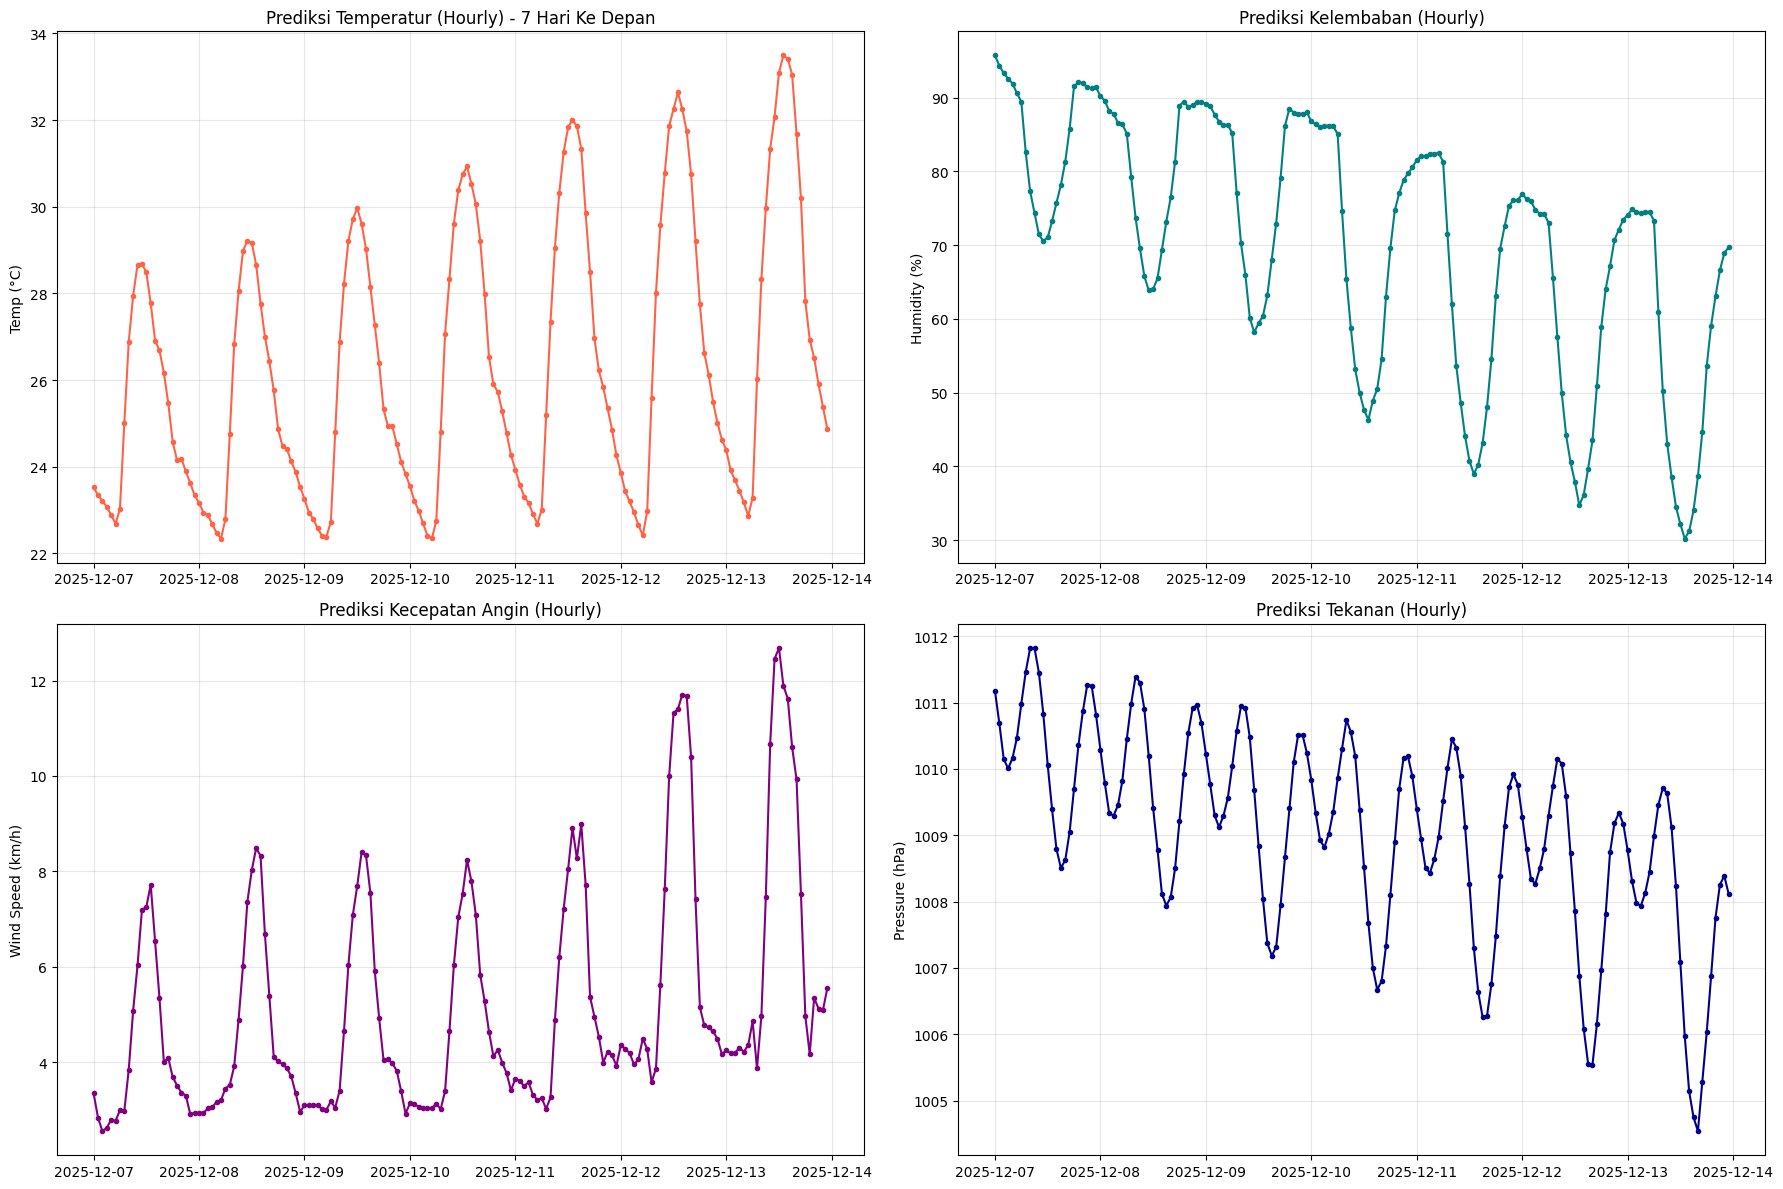

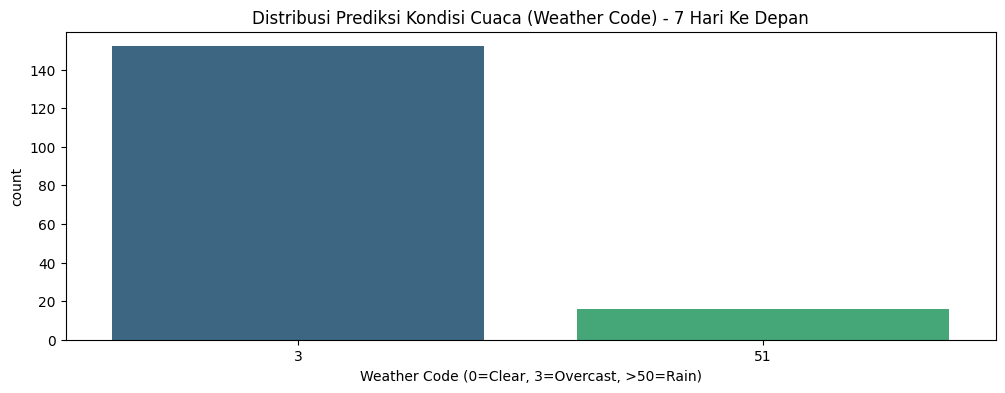

In [52]:
# 1. TABEL DATA HOURLY
print("📅 Tabel Prediksi Hourly (5 Baris Pertama):")
display(forecast_hourly.head())

# 2. VISUALISASI HOURLY
plt.figure(figsize=(18, 12))

# Subplot 1: Temperature
plt.subplot(2, 2, 1)
plt.plot(forecast_hourly['timestamp'], forecast_hourly['temp'], color='tomato', marker='o', markersize=3)
plt.title('Prediksi Temperatur (Hourly) - 7 Hari Ke Depan')
plt.ylabel('Temp (°C)')
plt.grid(True, alpha=0.3)

# Subplot 2: Humidity
plt.subplot(2, 2, 2)
plt.plot(forecast_hourly['timestamp'], forecast_hourly['humidity'], color='teal', marker='o', markersize=3)
plt.title('Prediksi Kelembaban (Hourly)')
plt.ylabel('Humidity (%)')
plt.grid(True, alpha=0.3)

# Subplot 3: Wind Speed
plt.subplot(2, 2, 3)
plt.plot(forecast_hourly['timestamp'], forecast_hourly['windspeed'], color='purple', marker='o', markersize=3)
plt.title('Prediksi Kecepatan Angin (Hourly)')
plt.ylabel('Wind Speed (km/h)')
plt.grid(True, alpha=0.3)

# Subplot 4: Pressure
plt.subplot(2, 2, 4)
plt.plot(forecast_hourly['timestamp'], forecast_hourly['sealevelpressure'], color='darkblue', marker='o', markersize=3)
plt.title('Prediksi Tekanan (Hourly)')
plt.ylabel('Pressure (hPa)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualisasi Weather Code (Bar Plot)
plt.figure(figsize=(12, 4))
sns.countplot(x='weather_code', data=forecast_hourly, palette='viridis')
plt.title('Distribusi Prediksi Kondisi Cuaca (Weather Code) - 7 Hari Ke Depan')
plt.xlabel('Weather Code (0=Clear, 3=Overcast, >50=Rain)')
plt.show()

### B. Hasil Prediksi Daily (7 Hari)

📅 Tabel Prediksi Daily (7 Hari):


,date,temp_min,temp_max,avg_temp,avg_humidity,avg_pressure,avg_wind_speed,weather_code_dominant
0,2025-12-07,22.826672,29.512489,25.016691,86.523804,1010.290649,4.620752,3
1,2025-12-08,22.783577,28.763096,25.266771,86.834129,1009.891479,5.654076,3
2,2025-12-09,23.090527,28.862728,25.292973,82.132095,1009.223877,4.876311,3
3,2025-12-10,22.884790,29.206766,25.013426,83.189766,1009.105591,4.682860,3
4,2025-12-11,22.936518,28.531027,24.957754,84.975655,1009.371826,4.511113,3
5,2025-12-12,22.737692,28.697449,25.234369,83.481598,1009.294922,5.101343,3
6,2025-12-13,23.038513,28.454687,25.290630,83.790901,1009.440369,6.063559,3


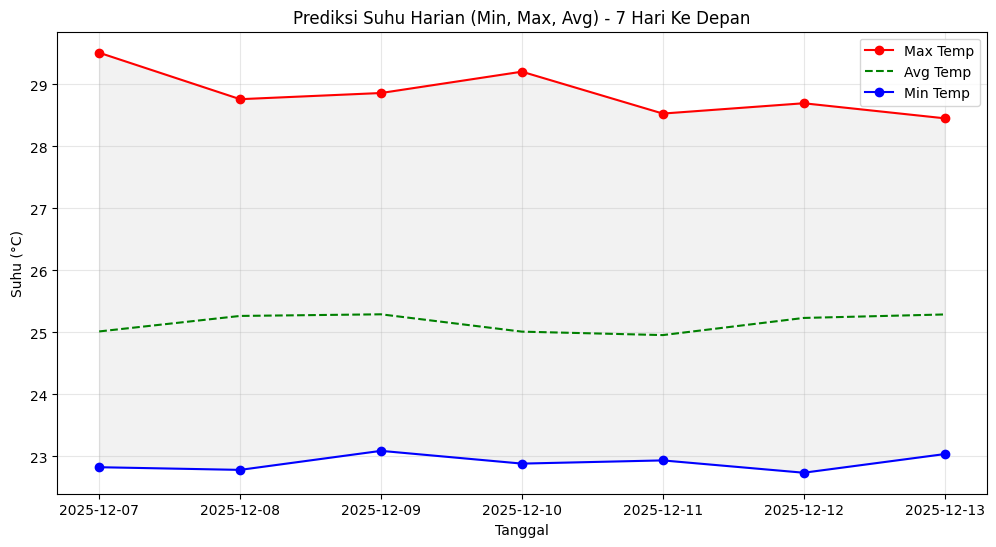

In [53]:
# 1. TABEL DATA DAILY
# Rename kolom agar sesuai request user (avg_temp, dll)
forecast_daily_display = forecast_daily.rename(columns={
    'temp_mean': 'avg_temp',
    'humidity_avg': 'avg_humidity',
    'pressure_avg': 'avg_pressure',
    'windspeed_avg': 'avg_wind_speed'
})

print("📅 Tabel Prediksi Daily (7 Hari):")
display(forecast_daily_display[['date', 'temp_min', 'temp_max', 'avg_temp', 
                                'avg_humidity', 'avg_pressure', 'avg_wind_speed', 
                                'weather_code_dominant']])

# 2. VISUALISASI DAILY (Suhu Min/Max/Avg)
plt.figure(figsize=(12, 6))
plt.plot(forecast_daily['date'], forecast_daily['temp_max'], 'r-o', label='Max Temp')
plt.plot(forecast_daily['date'], forecast_daily['temp_mean'], 'g--', label='Avg Temp')
plt.plot(forecast_daily['date'], forecast_daily['temp_min'], 'b-o', label='Min Temp')

plt.fill_between(forecast_daily['date'], forecast_daily['temp_min'], forecast_daily['temp_max'], color='gray', alpha=0.1)

plt.title('Prediksi Suhu Harian (Min, Max, Avg) - 7 Hari Ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Rangkuman

Notebook ini telah menyelesaikan:

1. **Persiapan Lingkungan** - Import semua pustaka
2. **Pemuatan Data** - Load dataset 23 kolom
3. **EDA** - Analisis distribusi, korelasi
4. **Feature Engineering** - Lag features untuk Hourly dan Daily
5. **Perbandingan Model** - 5 model regresi & 4 model klasifikasi
6. **Analisis Kinerja** - Evaluasi per-parameter dan Confusion Matrix
7. **Retraining & Penyimpanan** - 7 file model `.pkl` tersimpan
8. **Multi-Step Forecasting** - Recursive strategy
9. **Visualisasi Forecast** - Actual vs Predicted
10. **Dampak Inkremental** - R2 vs data size

**Output Files:**
```
models/
|- weather_model_combined.pkl
|- weather_model_hourly.pkl
|- weather_model_daily.pkl
|- weather_model_hourly_regressor.pkl
|- weather_model_hourly_classifier.pkl
|- weather_model_daily_regressor.pkl
|- weather_model_daily_classifier.pkl
```